<a href="https://colab.research.google.com/github/kashindra-mahato/SOC-support-system/blob/kashindra/authlog_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

##Imports

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pickle

##Parser for auth

In [3]:
def authParser(log_file):
  file_name = log_file
  file = open(file_name, "r")
  data = []
  order = ["date", "time", "ip", "process", "event"]
  
  for line in file.readlines():
    split1 = re.split(":", line, 3)
    event = split1[3]
    date = re.findall("^\S+\s+[0-9]{2}", line)
    time = re.findall("([0-9]{2}\\:[0-9]{2}\\:[0-9]{2})", line)[0]
    ip = re.findall("([a-z]{2}\\-[0-9]*\\-[0-9]*\\-[0-9]*\\-[0-9]*)", line)[0]
    process = re.findall("([a-zA-Z]*\\[[0-9]*\\])", line)[0]
    details = [date, time, ip, process, event]
    structure = {key:value for key, value in zip(order, details)}
    data.append(structure)
  return data

##parser for single line(string)

In [4]:
def authParserLine(line):
  order = ["date", "time", "ip", "process", "event"]
  
  split1 = re.split(":", line, 3)
  event = split1[3]
  date = re.findall("^\S+\s+[0-9]{2}", line)
  time = re.findall("([0-9]{2}\\:[0-9]{2}\\:[0-9]{2})", line)[0]
  ip = re.findall("([a-z]{2}\\-[0-9]*\\-[0-9]*\\-[0-9]*\\-[0-9]*)", line)[0]
  process = re.findall("([a-zA-Z]*\\[[0-9]*\\])", line)[0]
  details = [date, time, ip, process, event]
  structure = {key:value for key, value in zip(order, details)}
  
  return structure

##function for Cleaning

In [5]:
def clean(dataframe, column_name):
  dataframe[column_name] = dataframe[column_name].str.lower()
  # Remove numbers and special-characters from Event
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')
  # remove after 'user' including user :(
  dataframe[column_name] = dataframe[column_name].apply(lambda x: x.split(' user ')[0])
  return dataframe

##Stop word remover

In [6]:
def remStopWord(dataframe, column_name, s_words):
  import nltk
  from nltk.corpus import stopwords
  nltk.download('stopwords')
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(s_words)
  dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))
  return dataframe

##Tokenizer

In [7]:
def authToken(input_data):
  return list(set(str(input_data).split(' ')))

##Vectorizer

In [8]:
def authVectorizer(path, input_data):
  vectorizer = TfidfVectorizer(tokenizer=authToken)
  vectorizer.fit(input_data)
  vector_op = vectorizer.transform(input_data)
  pickle.dump(vectorizer, open(path + 'auth_vectorizer_model.sav', 'wb'))
  return vector_op, vectorizer

##principle component analyzer

In [9]:
def pca(path, input_data):
  pca = PCA(n_components=0.95) 
  pca.fit(input_data)
  data = pca.transform(input_data)
  pickle.dump(pca, open(path + 'auth_pca_model.sav', 'wb'))
  return data, pca

##training model

In [10]:
def train(path, input_data, mod):
  if mod == 'kmeans':
    model = KMeans(7)
    model.fit(input_data)
    data = model.transform(input_data)
    pickle.dump(model, open(path + 'auth_kmeans_model.sav', 'wb'))
    return data, model

  if mod == 'sgd':
    model = SGDClassifier(loss='perceptron')
    X = input_data.drop('y_label',axis=1)
    y = input_data['y_label']
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    model.fit(x_train, y_train)
    pickle.dump(model, open(path + 'auth_sgd_model.sav', 'wb'))
    print(model.score(x_test, y_test))
    return model


##model loader

In [11]:
def loadModel(path, mod_name):
  return pickle.load(open(path + 'auth_'+mod_name+'.sav', 'rb'))

##function to calculate distance between each instance and their respective centroids

In [12]:
def fromCentDistance(pca_data, model):
  centroids = model.cluster_centers_
  df_cent = pd.DataFrame(centroids)
  df_cent['label'] = [i for i in range(len(centroids))]
  df_pca_data = pd.DataFrame(pca_data)
  df_pca_data['label'] = model.predict(pca_data)
  df_pca_data_join = df_pca_data.join(df_cent, 
                                      on='label', 
                                      how='left', 
                                      lsuffix='_pca',
                                      rsuffix='_cent')
  df_pca_1 = df_pca_data_join.loc[:, "0_pca":"label_pca"]
  df_pca_1.drop('label_pca', axis=1, inplace=True)
  df_cent_1 = df_pca_data_join.loc[:, "0_cent":"label_cent"]
  df_cent_1.drop('label_cent', axis=1, inplace=True)
  list1 = df_pca_1.to_numpy().tolist()
  list2 = df_cent_1.to_numpy().tolist()
  distances = []
  for i in range(len(list1)):
    dist = distance.euclidean(list1[i],list2[i])
    distances.append(dist)
  
  return distances

##function to calculate modified_zscore

In [13]:
def modified_zscore(distance, consistency_correction=1.4826):
    
    median = np.median(distance)
    
    deviation_from_med = np.array(distance) - median
    
    mad = np.mean(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    
    return mod_zscore, mad

##function to plot anomalies(z>3)

In [14]:
def plot_anomaly(data, threshold):
    data = data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(data), len(data))
    mask_outliers = (data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], data[~mask_outliers],'o', color='b', label='normal')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Log Event', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Event')
    plt.ylabel('Modified z-score')
    plt.show()

#Training

In [15]:
# log = "/content/drive/MyDrive/Colab Notebooks/DATASET/auth.log"
log = '/home/iamdpk/Project Work/SOC-support-system/Dataset/auth.log'

In [16]:
path = '/home/iamdpk/Project Work/SOC-support-system/'

In [17]:
data = authParser(log)

In [18]:
df = pd.DataFrame(data)

In [19]:
df_copy = df.copy()

In [20]:
df_clean = clean(df,"event")

<ipython-input-5-4ca01a1ba164>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
<ipython-input-5-4ca01a1ba164>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')


In [21]:
stopwords = ['pam_unixcronsession' 'by', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth']

In [22]:
df_clean = remStopWord(df_clean, "event", stopwords)

[nltk_data] Downloading package stopwords to /home/iamdpk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
vector_op, vectorizer = authVectorizer(path, df_clean['event'])

/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
pca_data, pca = pca(path, vector_op.todense())

/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [25]:
model_data, model = train(path, pca_data, 'kmeans')

In [26]:
distance = fromCentDistance(pca_data, model)

In [27]:
df_copy['distance'] = distance

In [28]:
df_copy['label'] = model.labels_

In [29]:
mod_zscore, mad = modified_zscore(df_copy['distance'])

In [30]:
df_copy['mod_zscore'] = mod_zscore.tolist()

In [31]:
df_copy.loc[df_copy.mod_zscore>3, 'y_label'] = 'anomaly'
df_copy.loc[df_copy.mod_zscore<3, 'y_label'] = 'normal'

In [32]:
df_sgd = pd.DataFrame(vector_op.todense())

In [33]:
df_sgd['y_label'] = df_copy['y_label']

In [34]:
model = train(path, df_sgd, 'sgd')

0.9990211883924459


#Output

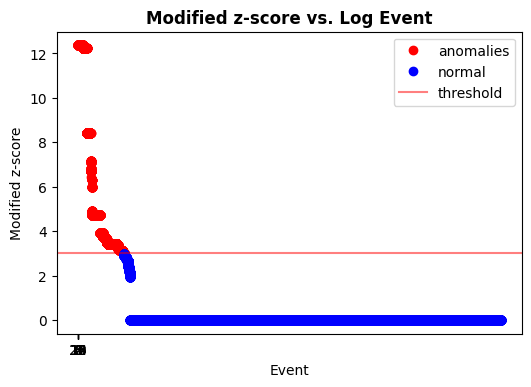

In [35]:
plot_anomaly(df_copy['mod_zscore'],3)

In [36]:
df.loc[df_copy.mod_zscore>3].event.unique()

array(['pam_unixcronsession session closed',
       'pam_unixcronsession session opened', 'connection closed',
       'receive identification',
       'warning cant get client address connection reset peer',
       'could write ident unknown', 'could write ident',
       'reverse mapping checking getaddrinfo internetsxcn failed possible breakin attempt',
       'reverse mapping checking getaddrinfo dialwzzjdynamicdatacomcn failed possible breakin attempt',
       'received disconnect comjcraftjschjschexception auth fail',
       'fatal write failed connection reset peer',
       'address maps hostedbyleasewebcom map back address possible breakin attempt',
       'bad protocol version identification',
       'address maps stlinesiscom map back address possible breakin attempt',
       'bad protocol version identification get http',
       'address maps bnbr map back address possible breakin attempt',
       'address maps reversecompletelnet map back address possible breakin attempt',
  

In [37]:
df_copy.loc[df_copy.mod_zscore>3].event.unique()

array([' pam_unix(cron:session): session closed for user root\n',
       ' pam_unix(cron:session): session opened for user root by (uid=0)\n',
       ' Connection closed by 122.225.103.87 [preauth]\n',
       ' Did not receive identification string from 187.12.249.74\n',
       ' Did not receive identification string from 196.200.90.236\n',
       ' Did not receive identification string from 1.93.26.70\n',
       ' Did not receive identification string from 122.225.109.208\n',
       ' Connection closed by 122.225.109.208 [preauth]\n',
       ' Connection closed by 122.225.109.123 [preauth]\n',
       ' Connection closed by 218.2.0.129 [preauth]\n',
       ' Connection closed by 218.2.0.121 [preauth]\n',
       ' Did not receive identification string from 218.75.153.170\n',
       " warning: can't get client address: Connection reset by peer\n",
       ' Could not write ident string to UNKNOWN\n',
       ' Could not write ident string to 218.75.153.170\n',
       ' Did not receive iden

In [38]:
df.loc[df_copy.label == 0].event.unique()

array(['received disconnect'], dtype=object)

In [39]:
df.loc[df_copy.label == 1].event.unique()

array(['input_userauth_request invalid'], dtype=object)

In [40]:
df.loc[df_copy.label == 2].event.unique()

array(['pam_unixcronsession session opened', 'receive identification',
       'warning cant get client address connection reset peer',
       'could write ident unknown', 'could write ident',
       'reverse mapping checking getaddrinfo internetsxcn failed possible breakin attempt',
       'reverse mapping checking getaddrinfo telemarnetbr failed possible breakin attempt',
       'reverse mapping checking getaddrinfo nslocal failed possible breakin attempt',
       'reverse mapping checking getaddrinfo dialwzzjdynamicdatacomcn failed possible breakin attempt',
       'received disconnect comjcraftjschjschexception auth fail',
       'reverse mapping checking getaddrinfo xxxstaticbusinesschelnyertelecomru failed possible breakin attempt',
       'reverse mapping checking getaddrinfo customertdatabrasilnetbr failed possible breakin attempt',
       'reverse mapping checking getaddrinfo adsldynamicseednettw failed possible breakin attempt',
       'reverse mapping checking getaddrinfo sta

In [41]:
df.loc[df_copy.label == 3].event.unique()

array(['invalid'], dtype=object)

In [42]:
df.loc[df_copy.label == 4].event.unique()

array(['pam_unixcronsession session closed', 'connection closed'],
      dtype=object)

In [43]:
df.loc[df_copy.label == 5].event.unique()

array(['disconnecting many authentication failures'], dtype=object)

In [44]:
df.loc[df_copy.label == 6].event.unique()

array(['fatal read socket failed connection reset peer',
       'fatal write failed connection reset peer'], dtype=object)

#Testing

In [45]:
# input = "Nov 30 09:22:03 ip-172-31-27-153 sshd[22218]: Did not receive identification string from 196.200.90.236"
input = log

In [46]:
log

'/home/iamdpk/Project Work/SOC-support-system/Dataset/auth.log'

In [47]:
data1 = authParser(input)

In [48]:
data_copy1 = pd.DataFrame(data1)

In [49]:
df1 = pd.DataFrame(data1)

In [50]:
df_copy1 = df1.copy()

In [51]:
df1_clean = clean(df1,"event")

<ipython-input-5-4ca01a1ba164>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
<ipython-input-5-4ca01a1ba164>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')


In [52]:
stopwords1 = ['pam_unixcronsession' 'by', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth']

In [53]:
df1_clean = remStopWord(df1_clean, "event", stopwords1)

[nltk_data] Downloading package stopwords to /home/iamdpk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
loaded_vectorizer = loadModel(path,'vectorizer_model')

In [55]:
vector_op1 = loaded_vectorizer.transform(df1_clean['event'])

In [56]:
loaded_pca = loadModel(path,'pca_model')

In [57]:
pca_data1 = loaded_pca.transform(vector_op1.todense())

/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [58]:
loaded_model_kmeans = loadModel(path,'kmeans_model')

In [59]:
one = pca_data1[1]

In [60]:
two = loaded_model_kmeans.cluster_centers_[1]

In [61]:
from scipy.spatial import distance
dis = distance.euclidean(one,two)
dis

1.3795384426529433

In [62]:
distance1 = fromCentDistance(pca_data1, loaded_model_kmeans)

In [63]:
distance1

[0.7177853526460152,
 1.0422433424217135,
 0.7177853526460152,
 0.2898049270814955,
 0.2898049270814955,
 0.2898049270814955,
 1.0422433424217135,
 0.7177853526460152,
 1.0422433424217135,
 0.7177853526460152,
 8.531798974115966e-15,
 9.190931700100366e-15,
 5.127275130692697e-14,
 1.052333914620755,
 1.0422433424217135,
 0.7177853526460152,
 1.052333914620755,
 1.0422433424217135,
 0.7177853526460152,
 1.052333914620755,
 1.052333914620755,
 0.2898049270814955,
 0.2898049270814955,
 8.531798974115966e-15,
 9.190931700100366e-15,
 0.2898049270814955,
 1.0422433424217135,
 0.7177853526460152,
 0.2898049270814955,
 0.2898049270814955,
 0.2898049270814955,
 0.2898049270814955,
 0.2898049270814955,
 0.2898049270814955,
 0.2898049270814955,
 0.00033876962937808935,
 1.0422433424217135,
 0.7177853526460152,
 1.0422433424217135,
 0.7177853526460152,
 5.127275130692697e-14,
 1.052333914620755,
 1.052333914620755,
 1.052333914620755,
 1.052333914620755,
 1.052333914620755,
 1.052333914620755,
 

In [64]:
df_copy1['distance'] = distance1

In [65]:
df_copy1['label'] = loaded_model_kmeans.labels_

In [66]:
mod_zscore, mad = modified_zscore(df_copy1['distance'])

In [67]:
df_copy1['mod_zscore'] = mod_zscore.tolist()

In [68]:
df_copy1

,date,time,ip,process,event,distance,label,mod_zscore
0,[Nov 30],06:39:00,ip-172-31-27-153,CRON[21882],pam_unix(cron:session): session closed for us...,7.177854e-01,4,8.430168e+00
1,[Nov 30],06:47:01,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session opened for us...,1.042243e+00,2,1.224083e+01
2,[Nov 30],06:47:03,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session closed for us...,7.177854e-01,4,8.430168e+00
3,[Nov 30],07:07:14,ip-172-31-27-153,sshd[22116],Connection closed by 122.225.103.87 [preauth]\n,2.898049e-01,4,3.403670e+00
4,[Nov 30],07:07:35,ip-172-31-27-153,sshd[22118],Connection closed by 122.225.103.87 [preauth]\n,2.898049e-01,4,3.403670e+00
...,...,...,...,...,...,...,...,...
86834,[Dec 31],22:26:20,ip-172-31-27-153,sshd[7998],Connection closed by 218.2.0.133 [preauth]\n,2.898049e-01,4,3.403670e+00
86835,[Dec 31],22:27:07,ip-172-31-27-153,sshd[8001],Connection closed by 218.2.0.133 [preauth]\n,2.898049e-01,4,3.403670e+00
86836,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],Invalid user admin from 218.2.0.133\n,8.531799e-15,3,-5.019793e-13
86837,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],input_userauth_request: invalid user admin [p...,9.190932e-15,1,-4.942380e-13


In [69]:
model_data1 = loaded_model_kmeans.predict(pca_data1)

In [70]:
model_data1

array([4, 2, 4, ..., 3, 1, 4], dtype=int32)

In [71]:
loaded_model2 = loadModel(path,'sgd_model')

In [72]:
model_data2 = loaded_model2.predict(pd.DataFrame(vector_op1.todense()))

In [73]:
model_data2

array(['anomaly', 'anomaly', 'anomaly', ..., 'normal', 'normal',
       'anomaly'], dtype='<U7')